In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
%matplotlib inline
from skimage import io
from tqdm import tqdm
import cv2
import gc

In [2]:
train_df=pd.read_csv(r'C:\Users\MAMATHA\Desktop\planet\train_classes.csv')
train_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [3]:
test_df=pd.read_csv(r'C:\Users\MAMATHA\Desktop\planet\sample_submission.csv')
test_df.head()

,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water
2,test_2,primary clear agriculture road water
3,test_3,primary clear agriculture road water
4,test_4,primary clear agriculture road water


In [4]:
label_list = []
for tag_str in train_df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        label_list.append(label)
label_list[:3]

['haze', 'primary', 'agriculture']

# Finding unique labels

In [5]:
from collections import Counter, defaultdict
count_ = defaultdict(int)
for i in label_list:
        count_[i] += 1
count_

defaultdict(int,
            {'haze': 2697,
             'primary': 37513,
             'agriculture': 12315,
             'clear': 28431,
             'water': 7411,
             'habitation': 3660,
             'road': 8071,
             'cultivation': 4547,
             'slash_burn': 209,
             'cloudy': 2089,
             'partly_cloudy': 7261,
             'conventional_mine': 100,
             'bare_ground': 862,
             'artisinal_mine': 339,
             'blooming': 332,
             'selective_logging': 340,
             'blow_down': 101})

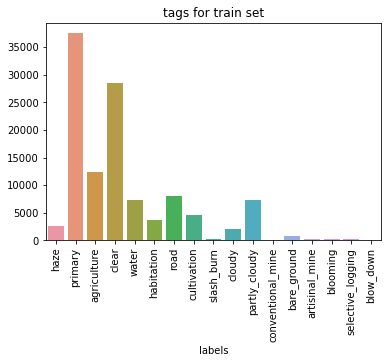

In [6]:
tags = list(count_.keys()) 
y = list(count_.values())
sns.barplot(x = tags, y = y);
plt.xlabel('labels');
plt.xticks(rotation = 90);
plt.title('tags for train set');

Placeholders for test set

Text(0.5, 1.0, 'Tag counts for test set')

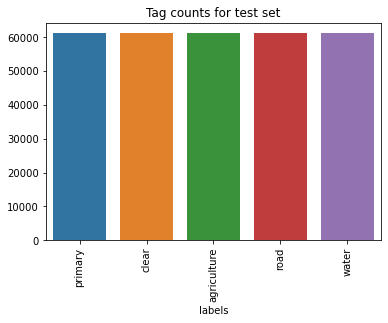

In [7]:
test_label = test_df['tags'].apply(lambda x: x.split(' '))
from collections import Counter, defaultdict
test_counts = defaultdict(int)
for i in test_label:
    for j in i:
        test_counts[j] += 1

tag_list_test=list(test_counts.keys()) 
test_count=list(test_counts.values())
sns.barplot(x=tag_list_test, y = test_count);
plt.xlabel('labels');
plt.xticks(rotation = 90);
plt.title('Tag counts for test set')

# visualize an image

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img=mpimg.imread('C:\\Users\\MAMATHA\\Desktop\\planet\\train-jpg\\train_8.jpg')

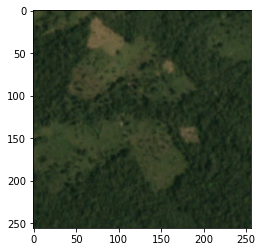

In [9]:
imgplot = plt.imshow(img)

Dictonary for class label and its respective numerical value

In [10]:
class_label = { tag: name for name, tag in enumerate(tags)}
class_label

{'haze': 0,
 'primary': 1,
 'agriculture': 2,
 'clear': 3,
 'water': 4,
 'habitation': 5,
 'road': 6,
 'cultivation': 7,
 'slash_burn': 8,
 'cloudy': 9,
 'partly_cloudy': 10,
 'conventional_mine': 11,
 'bare_ground': 12,
 'artisinal_mine': 13,
 'blooming': 14,
 'selective_logging': 15,
 'blow_down': 16}

MAKING AN ARRAY OF UNIQUE LABELS

In [11]:
train_path = 'C:\\Users\\MAMATHA\\Desktop\\planet\\train-jpg'
test_path = 'C:\\Users\\MAMATHA\\Desktop\\planet\\test-jpg'

In [12]:
train_df[train_df['image_name'] == 'train_10']

,image_name,tags
10,train_10,agriculture clear primary slash_burn water


In [13]:
unique_labels = set()
def append_labels(tags):
    for tag in tags.split():
        unique_labels.add(tag)

train_classes = train_df.copy()
train_classes['tags'].apply(append_labels)
unique_labels = list(unique_labels)
print(unique_labels)

['selective_logging', 'haze', 'cultivation', 'cloudy', 'bare_ground', 'agriculture', 'road', 'primary', 'clear', 'habitation', 'artisinal_mine', 'slash_burn', 'blow_down', 'partly_cloudy', 'conventional_mine', 'blooming', 'water']


In [14]:
len(unique_labels)

17

In [15]:
assert len(train_df['image_name'].unique()) == train_df.shape[0]

In [16]:
for tag in unique_labels:   #one hot encoding
    train_classes[tag] = train_classes['tags'].apply(lambda x: 1 if tag in x.split() else 0)
    
# adding '.jpg' extension to 'image_name'
train_classes['image_name'] = train_classes['image_name'].apply(lambda x: '{}.jpg'.format(x)) 
train_classes.head()

,image_name,tags,selective_logging,haze,cultivation,cloudy,bare_ground,agriculture,road,primary,clear,habitation,artisinal_mine,slash_burn,blow_down,partly_cloudy,conventional_mine,blooming,water
0,train_0.jpg,haze primary,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,train_1.jpg,agriculture clear primary water,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,1
2,train_2.jpg,clear primary,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0
3,train_3.jpg,clear primary,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0
4,train_4.jpg,agriculture clear habitation primary road,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0


In [17]:
import tensorflow as tf

In [18]:
y_col = list(train_classes.columns[2:]) # storing the tags column names as a variable

# initializing an image generator with some data augumentation
image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

# loading images from dataframe
X = image_gen.flow_from_dataframe(dataframe=train_classes, \
        directory='C:\\Users\\MAMATHA\\Desktop\\planet\\train-jpg', x_col='image_name', y_col=y_col, \
       target_size=(64, 64), class_mode='raw', seed=1, batch_size=64)

Found 40479 validated image filenames.


In [19]:
# let's abitrarily view an image
x54 = X[0][0][54] # first batch, images, 109th image
y54 = X[0][1][54] # first batch, labels, 109th label
print("each image's shape is {}".format(x54.shape))
print("each label's shape is {}".format(y54.shape))
print('we have {} batches'.format(len(X)))
print('each batch has {} images/labels'.format(X[0][0].shape[0]))
print('40479/128 is {:.2F}, so the last batch will have {} images/labels'.format(40479/128, X[316][0].shape[0]))

each image's shape is (64, 64, 3)
each label's shape is (17,)
we have 633 batches
each batch has 64 images/labels
40479/128 is 316.24, so the last batch will have 64 images/labels


In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import SGD

In [21]:
def fbeta(ytrue , ypred, beta=2, epsilon=1e-4):
    beta_squarred = beta**2

    ytrue = tf.cast(ytrue, tf.float32)
    ypred = tf.cast(tf.greater(tf.cast(ypred, tf.float32), tf.constant(0.5)), tf.float32)
        
    tp = tf.reduce_sum(ytrue * ypred, axis=1)
    fp = tf.reduce_sum(ypred, axis=1) - tp
    fn = tf.reduce_sum(ytrue, axis=1) - tp
    
    precision = tp/(tp+fp+epsilon)
    recall = tp/(tp+fn+epsilon)
    
    fb = (1+beta_squarred)*precision*recall / (beta_squarred*precision + recall + epsilon)
    return fb

In [22]:
def multi_label_acc(ytrue , ypred, epsilon=1e-4):
    
    ytrue = tf.cast(ytrue, tf.float32)
    ypred = tf.cast(tf.greater(tf.cast(ypred, tf.float32), tf.constant(0.5)), tf.float32)
    
    tp = tf.reduce_sum(ytrue * ypred, axis=1)
    fp = tf.reduce_sum(ypred, axis=1) - tp
    fn = tf.reduce_sum(ytrue, axis=1) - tp
    
    ytrue = tf.cast(ytrue, tf.bool)
    ypred = tf.cast(ypred, tf.bool)
    
    tn = tf.reduce_sum(tf.cast(tf.logical_not(ytrue), tf.float32) * tf.cast(tf.logical_not(ypred), tf.float32),\
                       axis=1)
    
    return (tp+tn)/(tp+tn+fp+fn+epsilon)

In [23]:
def build_model():
    in_shape=(64, 64, 3)
    out_shape=17

    # load mannequin

    mannequin = VGG16(include_top=False, input_shape=in_shape)

    # mark loaded layers as not trainable

    for layer in mannequin.layers:
        layer.trainable = False

    # enable final vgg block to be trainable

    mannequin.get_layer("block5_conv1").trainable = True

    mannequin.get_layer("block5_conv2").trainable = True

    mannequin.get_layer("block5_conv3").trainable = True

    mannequin.get_layer("block5_pool").trainable = True

    # add new classifier layers

    flat1 = Flatten()(mannequin.layers[-1].output)

    class1 = Dense(128, activation="relu", kernel_initializer="he_uniform")(flat1)

    output = Dense(out_shape, activation="sigmoid")(class1)

    # outline new mannequin

    mannequin = Model(inputs=mannequin.inputs, outputs=output)

    # compile mannequin
    
    choose = SGD(lr=0.01, momentum=0.9)

    mannequin.compile(optimizer=choose, loss="binary_crossentropy", metrics=[fbeta, multi_label_acc])
    
    return mannequin

In [24]:
save_best_check_point = ModelCheckpoint(filepath='best_model.hdf5', monitor='val_fbeta',mode='max', save_best_only=True, save_weights_only=True)

In [25]:
train_image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255,validation_split=0.2)

# generating the 80% training image data
train_gen = train_image_gen.flow_from_dataframe(dataframe=train_classes, \
        directory='C:\\Users\\MAMATHA\\Desktop\\planet\\train-jpg', x_col='image_name', y_col=y_col, \
       target_size=(64, 64), class_mode='raw', seed=0, batch_size=64, subset='training')

# generating the 20% validation image data
val_gen = train_image_gen.flow_from_dataframe(dataframe=train_classes, \
        directory='C:\\Users\\MAMATHA\\Desktop\\planet\\train-jpg', x_col='image_name', y_col=y_col, \
       target_size=(64,64), class_mode='raw', seed=0, batch_size=64, subset='validation')

Found 32384 validated image filenames.
Found 8095 validated image filenames.


In [26]:
# setting step size for training and validation image data
step_train_size = int(np.ceil(train_gen.samples / train_gen.batch_size))
step_val_size = int(np.ceil(val_gen.samples / train_gen.batch_size))

In [27]:
step_train_size+step_val_size

633

In [28]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
model1 = build_model() # building a sequential model for training

model1.fit(x=train_gen, steps_per_epoch=step_train_size, validation_data=val_gen, validation_steps=step_val_size,epochs=1, callbacks=[save_best_check_point])

c:\users\mamatha\anaconda3\envs\sss\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


506/506 [==============================] - 755s 1s/step - loss: 0.1691 - fbeta: 0.7719 - multi_label_acc: 0.9341 - val_loss: 0.1479 - val_fbeta: 0.8117 - val_multi_label_acc: 0.9417


In [30]:
sample_submission = test_df.copy()
sample_submission['image_name'] = sample_submission['image_name'].apply(lambda x: '{}.jpg'.format(x))
sample_submission.head()

,image_name,tags
0,test_0.jpg,primary clear agriculture road water
1,test_1.jpg,primary clear agriculture road water
2,test_2.jpg,primary clear agriculture road water
3,test_3.jpg,primary clear agriculture road water
4,test_4.jpg,primary clear agriculture road water


In [32]:
test1_df = sample_submission.iloc[:40669]['image_name'].reset_index().drop('index', axis=1)
test1_df.head()
test1_df.shape
# initializing an image data generator object for the first 40669 images in the sample submission dataframe
test_image_gen1 = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

# generating the image data for the first 40669 images in the sample submission dataframe
test_gen1 = test_image_gen1.flow_from_dataframe(dataframe=test1_df, directory='C:\\Users\\MAMATHA\\Desktop\\planet\\test-jpg', x_col='image_name', y_col=None, batch_size=128, shuffle=False, class_mode=None, target_size=(64,64))

# setting the step size for the testing set for the first 40669 images in the sample submission dataframe
step_test_size1 = int(np.ceil(test_gen1.samples / test_gen1.batch_size))

Found 40669 validated image filenames.


In [34]:
test_gen1.reset() # reseting the generator to be sure of avoiding shuffling
pred1 = model1.predict(test_gen1, steps=step_test_size1, verbose=1)

318/318 [==============================] - 745s 2s/step


In [35]:
test_file_names1 = test_gen1.filenames # storing the filenames (images names) of the first 40669 images names in 
                                       # the sample submission dataframe as ordered in the prediction as a 
                                       # variable

# converting the predictions of the first 40669 to tag names
pred_tags1 = pd.DataFrame(pred1)
pred_tags1 = pred_tags1.apply(lambda x: ' '.join(np.array(unique_labels)[x > 0.5]), axis=1)

# converting the predictions of the first 40669 to a dataframe
result = pd.DataFrame({'image_name': test_file_names1, 'tags': pred_tags1})
result.head()

,image_name,tags
0,test_0.jpg,primary clear
1,test_1.jpg,primary clear
2,test_2.jpg,primary partly_cloudy
3,test_3.jpg,primary clear
4,test_4.jpg,primary partly_cloudy


In [38]:
# removing the .jpg extension from 'iamge_name' column
result['image_name'] = result['image_name'].apply(lambda x: x[:-4])
result.head()

,image_name,tags
0,test_0,primary clear
1,test_1,primary clear
2,test_2,primary partly_cloudy
3,test_3,primary clear
4,test_4,primary partly_cloudy


In [39]:
result.to_csv('final_submission.csv', index=False) # saving the predictions